# Welcome to Structure From Motion!
This is the final step — and one of the most exciting project you can build in 3D Computer Vision!

Here's what we're going to do:

*   Load 2 or more images
*   Match Features
*   Estimate the Fundamental Matrix
*   Estimate the Essential Matrix
*   Recover R and T
*   Triangulate
*   Reconstruct in 3D



In [1]:
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

import cv2
import numpy as np

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/fountain.zip && unzip fountain.zip

--2025-10-27 07:09:07--  https://stereo-vision.s3.eu-west-3.amazonaws.com/fountain.zip
Resolving stereo-vision.s3.eu-west-3.amazonaws.com (stereo-vision.s3.eu-west-3.amazonaws.com)... 3.5.205.131, 16.12.18.22
Connecting to stereo-vision.s3.eu-west-3.amazonaws.com (stereo-vision.s3.eu-west-3.amazonaws.com)|3.5.205.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69686268 (66M) [application/zip]
Saving to: ‘fountain.zip’

fountain.zip        100%[===================>]  66.46M  18.9MB/s    in 4.3s    

2025-10-27 07:09:12 (15.6 MB/s) - ‘fountain.zip’ saved [69686268/69686268]

Archive:  fountain.zip
   creating: fountain/
  inflating: __MACOSX/._fountain     
  inflating: fountain/00011.png.camera  
  inflating: __MACOSX/fountain/._00011.png.camera  
  inflating: fountain/0003.png.camera  
  inflating: __MACOSX/fountain/._0003.png.camera  
  inflating: fountain/.DS_Store      
  inflating: __MACOSX/fountain/._.DS_Store  
  inflating: fountain/0006.png.camera  

### 1. Images

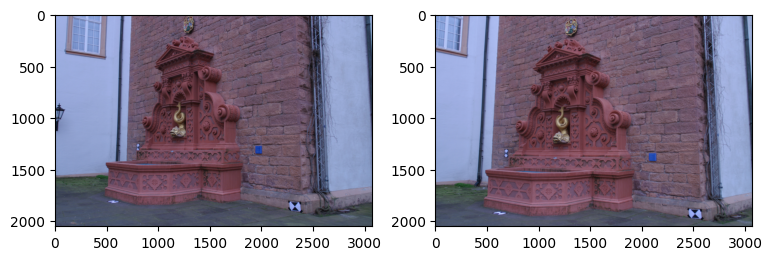

In [3]:
#Reading two images for reference
img1 = cv2.imread('fountain/0001.png')
img2 = cv2.imread('fountain/0002.png')

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
f, (ax0, ax1) = plt.subplots(1,2,figsize=(9,4))
ax0.imshow(img1)
ax1.imshow(img2)
plt.show()

### 2. Feature Matching

In [4]:
def GetImageMatches(img1,img2):
    ### TODO
    # Use SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Use BFMatcher to find the best matches
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return keypoints1, descriptors1, keypoints2, descriptors2, good_matches

def GetAlignedMatches(kp1,desc1,kp2,desc2,matches):
    ### TODO
    img1pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    img2pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    img1idx = np.array([m.queryIdx for m in matches])
    img2idx = np.array([m.trainIdx for m in matches])
    
    return img1pts,img2pts,img1idx,img2idx

#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=GetImageMatches(img1,img2)
#kp1,desc1,kp2,desc2,matches, img1pts, img2pts = feature_matching(img1, img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

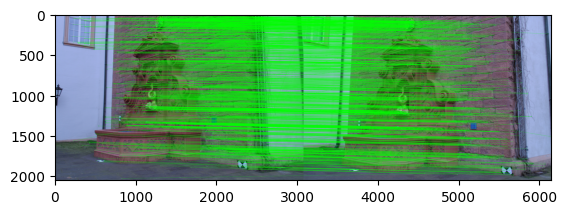

In [5]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    flags = 2)

plt.imshow(cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params))

### 3. Estimate Fundamental Matrix

In [6]:
F,mask=cv2.findFundamentalMat(img1pts, img2pts, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.99) #TODO
mask=mask.astype(bool).flatten()

In [7]:
print(mask)

[ True  True False ... False False  True]


In [8]:
print(len(img1pts))
print(len(img2pts))
print(len(mask))

1577
1577
1577


In [9]:
#Inliers // Optional
img1pts = img1pts[mask==True]
img2pts = img2pts[mask==True]
mask = len(img1pts) * [True] ### We need the match matrix to be the same size of the number of points

In [10]:
print(len(img1pts))
print(len(img2pts))
print(len(mask))

1135
1135
1135


### Compute Epipolar Lines

In [11]:
def ComputeEpiline(pts, index, F):
    if pts.shape[1]==2:
        #converting to homogenous coordinates if not already
        pts = cv2.convertPointsToHomogeneous(pts)[:,0,:]

    if index==1:
        lines = F.dot(pts.T)
    elif index==2:
        lines = F.T.dot(pts.T)

    return lines.T

In [12]:
lines2=ComputeEpiline(img1pts[mask],1,F)
lines1=ComputeEpiline(img2pts[mask],2,F)

In [13]:
def drawlines(img1,img2,lines,pts1,pts2,drawOnly=None,linesize=7,circlesize=10):
    r,c = img1.shape[:-1]

    img1_, img2_ = np.copy(img1), np.copy(img2)

    drawOnly = lines.shape[0] if (drawOnly is None) else drawOnly

    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        img1_ = cv2.line(img1_, (x0,y0), (x1,y1), color,linesize)
        img1_ = cv2.circle(img1_,tuple(pt1.astype(int)),circlesize,color,-1)
        img2_ = cv2.circle(img2_,tuple(pt2.astype(int)),circlesize,color,-1)

        i += 1

        if i > drawOnly:
            break

    return img1_,img2_

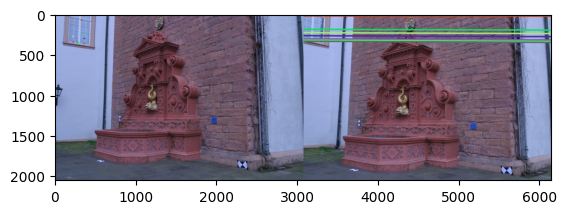

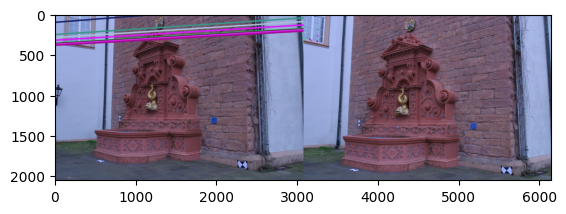

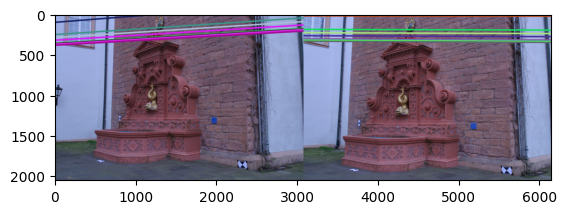

In [14]:
epilines1, epilines2 = drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,linesize=18,circlesize=10)
epilines3, epilines4 = drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,linesize=18,circlesize=10)

epilines12 = np.concatenate((epilines2, epilines1), axis=1)
plt.imshow(epilines12)
plt.show()

epilines34 = np.concatenate((epilines3, epilines4), axis=1)
plt.imshow(epilines34)
plt.show()

epilines = np.concatenate((epilines3, epilines1), axis=1)

plt.imshow(epilines)
plt.show()

### 4. Essential Matrix

In [15]:
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
E = np.transpose(K) @ F @ K #TODO

In [16]:
print(E)

[[ -0.09982029  -1.19388016  -0.47315941]
 [  6.47646694  -0.86070803  34.05660155]
 [ -0.41867555 -34.8721273   -0.70435088]]


### 5. Camera Poses

In [17]:
pts_rec, r_rec, t_rec, mask_rec = cv2.recoverPose(E, img1pts[mask], img2pts[mask]) #TODO

### 6. Triangulation

In [18]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t):
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]

    pts4d = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]

    return pts3d

In [19]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,r_rec,t_rec) #TODO

### 7. Save PLY

In [20]:
def pts2ply(pts,filename='out.ply'):
    f = open(filename,'w')
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write('element vertex {}\n'.format(pts.shape[0]))

    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')

    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')

    f.write('end_header\n')

    for pt in pts:
        f.write('{} {} {} 255 255 255\n'.format(pt[0],pt[1],pt[2]))
    f.close()

In [21]:
pts2ply(pts3d)

### 9. Try Loop

In [22]:
import collections
topologies = collections.OrderedDict()
topologies['360'] = tuple(zip((0,1,2,3,4,5,6,7,8,9,10,11),
                          (1,2,3,4,5,6,7,8,9,10,11,0)))

topologies['overlapping'] = tuple(zip((0,1,2,3,4,5,6,7,8,9),
                          (1,2,3,4,5,6,7,8,9,10)))

topologies['adjacent'] = tuple(zip((0,2,4,6,8,10),
                     (1,3,5,7,9,11)))

topologies['skipping_1'] = tuple(zip((0,3,6,9),
                 (1,4,7,10)))

topologies['skipping_2'] = tuple(zip((0,4,8),
                 (1,5,9)))

topologies["zero"] = tuple(zip((0,0,0),
                 (1,1,1)))
topologies["custom"] = tuple(zip((0,0,0),
                 (1,2,3)))

In [23]:
import glob
import os

os.rename("fountain/00010.png","fountain/0010.png")
os.rename("fountain/00011.png","fountain/0011.png")
images= sorted(glob.glob("fountain/*.png"))

print(images)

images_cv = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in images]

['fountain/0001.png', 'fountain/0002.png', 'fountain/0003.png', 'fountain/0004.png', 'fountain/0005.png', 'fountain/0006.png', 'fountain/0007.png', 'fountain/0008.png', 'fountain/0009.png', 'fountain/0010.png', 'fountain/0011.png']


0


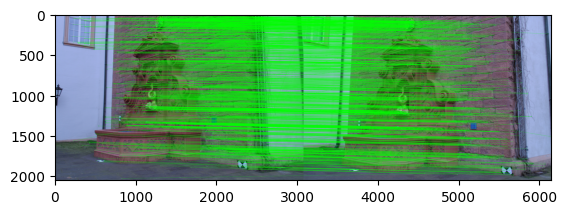

1


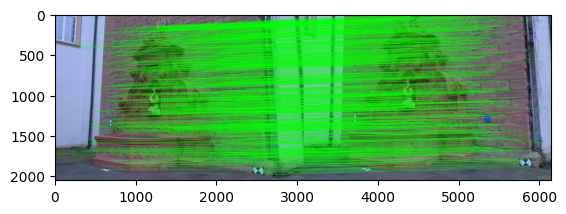

2


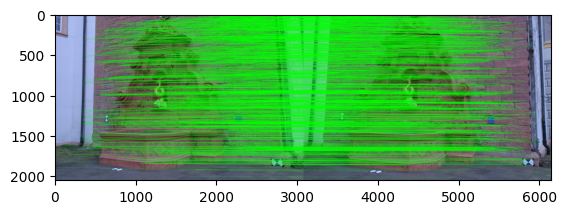

3


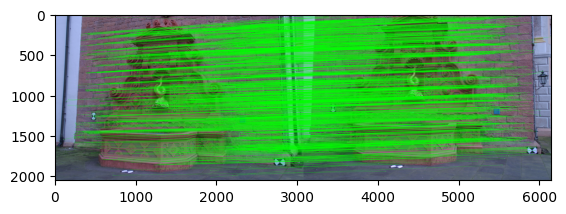

4


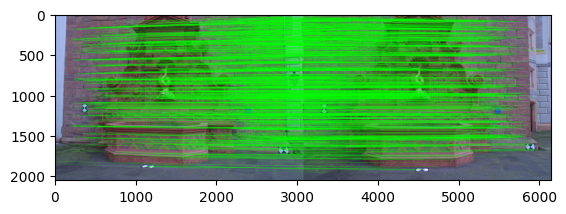

5


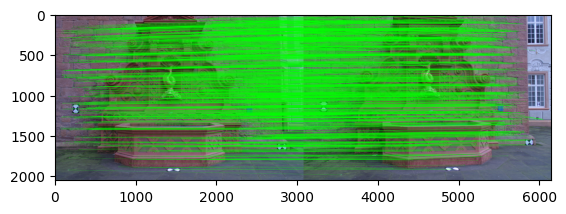

6


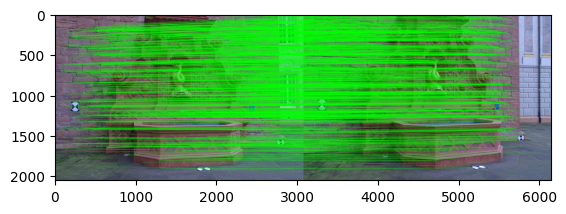

7


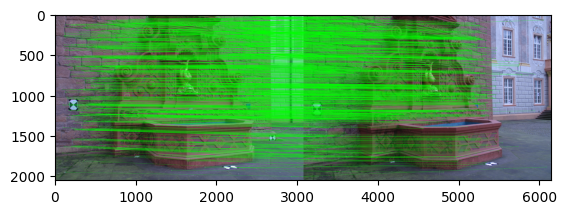

8


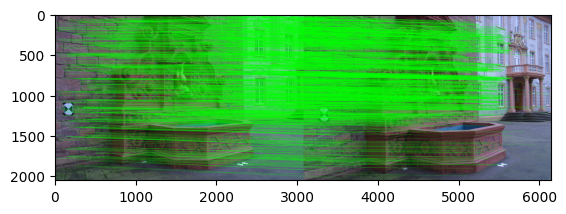

9


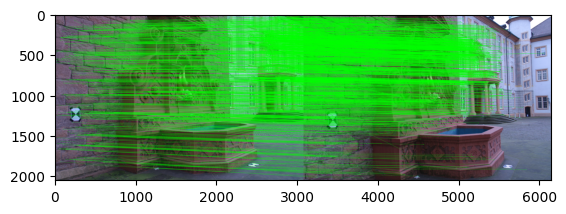

In [24]:
def main(K, images_cv, topology):
    xyz_global_array = [None]*len(topology)
    for pair_index, (left_index,right_index) in enumerate(topology):
        print(pair_index)
        img1 = images_cv[left_index]
        img2 = images_cv[right_index]

        # 1. Feature Matching
        kp1,desc1,kp2,desc2,matches=GetImageMatches(img1,img2)
        img1pts,img2pts,img1idx,img2idx=GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    flags = 2)

        plt.imshow(cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params))
        plt.show()

        #2. Fundamental
        F, mask = cv2.findFundamentalMat(img1pts, img2pts, method=cv2.FM_7POINT)
        mask=mask.astype(bool).flatten()

        #2.2 Inliers // Optional
        img1pts = img1pts[mask==True]
        img2pts = img2pts[mask==True]
        mask = len(img1pts) * [True] ### We need the match matrix to be the same size of the number of points

        #3. Essential
        E = K.T.dot(F.dot(K))

        #4. R, T
        #R1,R2,t = ExtractCameraPoses(E)
        #t = t[:,np.newaxis]
        pts_rec, r_rec, t_rec, mask_rec = cv2.recoverPose(E, img1pts, img2pts)

        #5. Triangulate
        #pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t)
        pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,r_rec,t_rec)

        #6. Add to Global Points
        xyz_global_array[pair_index] = pts3d

    return xyz_global_array

full_pts3d = main(K, images_cv, topologies["overlapping"])

In [25]:
for idx, points in enumerate(full_pts3d):
    pts2ply(full_pts3d[idx], "out_1_{}.ply".format(idx))
    print("number of points :", points.shape[0])

number of points : 1356
number of points : 1611
number of points : 1662
number of points : 1562
number of points : 1798
number of points : 1876
number of points : 1843
number of points : 1380
number of points : 1893
number of points : 1937


In [26]:
xyz = np.vstack(full_pts3d)
pts2ply(xyz, "out_full.ply")